In [1]:
import numpy as np
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
from matplotlib import pyplot
from keras.preprocessing import sequence

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

In [4]:
import matplotlib.pyplot as plt

## 1. Analisis de Sentimientos usando RNN
---

Hoy en dıa, una aplicacion relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta seccion abordaremos el problema de procesar el texto contenido en comentarios u opiniones (review) sobre una pelıcula para determinar su polaridad, es decir, determinar si refleja un sentiemiento positivo o negativo. Usaremos el Large Movie Review Dataset, tambien conocido como IMDB dataset que contiene 50000 comentarios de pelıculas etiquetadas como buenas o malas (50 %-50 % train-testing). Este dataset fue recolectado por investigadores de Stanford [5] y utilizado en la competencia Kaggle [6].

![title](imagenes/kaggle.png)

**(a) Cargue los datos:** 

Conjunto de datos de 25.000 revisiones de películas de IMDB, etiquetado por el sentimiento (positivo / negativo). Las revisiones han sido preprocesadas y cada revisión se codifica como una secuencia de índices de palabras (enteros). Por conveniencia, las palabras son indexadas por la frecuencia general en el conjunto de datos, de modo que por ejemplo el número entero "3" codifica la tercera palabra más frecuente en los datos.

In [5]:
np.random.seed(3)
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=15)

** (b) Estudie la distribucion del largo de los textos a procesar. Estudie tambien la frecuencia con la que aparecen las palabras en todo el dataset. ¿Se observa una ley Zipf? ¿Cambia el resultado cuando se separan los textos de acuerdo a su clase/categorıa? Comente.** 

In [6]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [7]:
print("Datos de Entrenamiento: ")
print(X.shape)
print(y.shape)

Datos de Entrenamiento: 
(50000,)
(50000,)


In [8]:
print ("Categorías (clasificación) ",str(np.unique(y)), "= (positivo / negativo)")

Categorías (clasificación)  [0 1] = (positivo / negativo)


In [9]:
print ("Numero total de palabras unicas en el Dataset: ",str(len(np.unique(np.hstack(X)))))

Numero total de palabras unicas en el Dataset:  88585


Como podemos ver, el numero de palabras únicas es reducido en comparación al tamaño del dataset, es como veremos mas adelante no es particularmente extraño si por el contrario esta en sintonía con la ley de Zipf’s 

In [9]:
result = list(map(len, X))

In [10]:
print("El promedio de palabras en las reseñas es %.2f con desviación estándar de %.2f" % (np.mean(result), np.std(result)))

El promedio de palabras en las reseñas es 234.76 con desviación estándar de 172.91


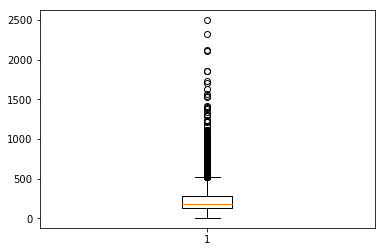

In [11]:
pyplot.boxplot(result)
pyplot.show()

La ley de Zipf’s dice:

`"..Un pequeño número de palabras son utilizadas con mucha frecuencia, mientras que frecuentemente ocurre que un gran número de palabras son poco empleadas."`

Ley Zipf’s se cumple a cabalidad en las reseñas,  Como podemos ver en gráfico existe una gran concentración de las frecuencias en un grupo acotado de palabras  300 a 500 palabras, Aunque no se visualiza cuales son estas palabras, estas reseñas(corpus) siguen también el comportamiento del idioma inglés por lo cual estas palabras con mayor frecuencia deben tratase de stopswor’s .Ademas como pudimos constatar el promedio de palabras por reseñas de cercano a los 270.

** c) Cargue nuevamente el dataset, pero esta vez extrayendo solo las 3000 palabras mas relevantes y acotando el largo maximo para un comentario en 500 palabras. Los comentarios con un largo menor deben ser rellenados con 0 (padding). ¿Porque es necesario hacer esto ultimo?** 

Como ya se indico el dataset de IMDB Movie reviews de Keras, ya esta pre-procesado, donde las palabras fueron indexadas por su frecuencia general en el conjunto de datos, lo cual ajustando el parámetro **num_words con el valor 3000, obtendremos las 3000 palabras con mayor frecuencia.** 

Así también ajustando el parámetro **maxlen con el valor 500 solo conservaremos los comentarios que tengan hasta este largo. **

**Los comentarios con un largo menor deben ser rellenados con 0 para que la red reciba todas los ejemplos del mismo tamaño.**

In [41]:
#np.random.seed(3)
#(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=3000, maxlen=500,seed=15)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=3000,seed=15)

In [42]:
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

In [43]:
pred_x_train = np.zeros(shape=(len(X_train),1))
pred_x_test = np.zeros(shape=(len(X_test),1))

In [44]:
print("Datos de Entrenamiento: ")
print(X_train.shape)
print(X_test.shape)

Datos de Entrenamiento: 
(25000, 500)
(25000, 500)


**(d)Entrene una red LSTM para aprender a clasificar el texto y evalue su desempeño. Esta red debe procesar la secuencia de 500 palabras a las que hemos reducido (o aumentado) cada review. Como las palabras corresponden a datos esencialmente categoricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformacion entrenable desde el espacio de representacion original (discreto) a Rd, con d la dimensionalidad del embedding.** 

In [17]:
top_words = 3000
embedding_vector_length = 32

In [18]:
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=500))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #relacionado la clasificacion binaria

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 348s - loss: 0.5108 - acc: 0.7363 - val_loss: 0.3636 - val_acc: 0.8461

In [20]:
scores = model.evaluate(X_test, y_test, verbose=0)

In [21]:
print("")
print("Accuracy del modelo: %.2f%%" % (scores[1]*100))
print("Loss del modelo : %.2f%%" % (scores[0]*100))


Accuracy del modelo: 86.91%
Loss del modelo : 31.31%


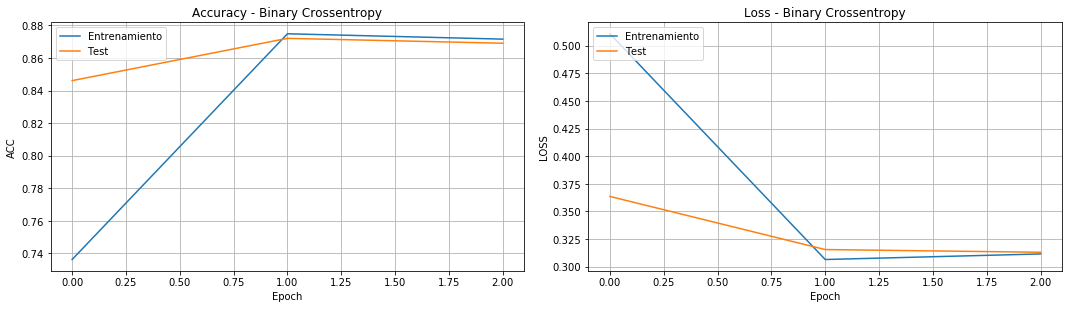

In [26]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Accuracy - Binary Crossentropy')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Loss - Binary Crossentropy')  
plt.ylabel('LOSS')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

Apesar que el numero epochs es pequeño de todas maneras noe permite ver la rapida convergencia del modelo, que presenta resultados de Accuracy del modelo: 86.91%. Lo cual sera contrastado con los resultados de las otras actividades. 

**(e) Varıe la dimensionalidad del embedding inicial y determine si aumenta o disminuye el error de clasificación. Comente.**

Con el fin de poder realizar las pruebas de distintas configuraciones de las arquitecturas a evaluar, se modularizo la creación de un modelo así también el entrenamiento de estos modelos en dos funciones que podemos ver a comunicación:

In [45]:
def createModelo(_top_words, _embedding_vector_length,_input_length,_lstm):
    model = Sequential()
    model.add(Embedding(_top_words, _embedding_vector_length, input_length=_input_length))
    model.add(LSTM(_lstm))
    model.add(Dense(1, activation='sigmoid'))
    return model

### Crear Modelos los 4 modelos [16-32-64-128]

In [47]:
#Caso 1 dimensionalidad del embedding = 16
top_words = 3000
embedding_vector_length = 16
input_length=500
lstm = 100
model_16 = createModelo(top_words, embedding_vector_length,input_length,lstm)
model_16.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #relacionado la clasificacion binaria
model_16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 500, 16)           48000     
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               46800     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 94,901
Trainable params: 94,901
Non-trainable params: 0
_________________________________________________________________


In [48]:
#Caso 2 dimensionalidad del embedding = 32
top_words = 3000
embedding_vector_length = 32
input_length=500
lstm = 100
model_32 = createModelo(top_words, embedding_vector_length,input_length,lstm)
model_32.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #relacionado la clasificacion binaria
model_32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 500, 32)           96000     
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 149,301
Trainable params: 149,301
Non-trainable params: 0
_________________________________________________________________


In [49]:
#Caso 3 dimensionalidad del embedding = 64
top_words = 3000
embedding_vector_length = 64
input_length=500
lstm = 100
model_64 = createModelo(top_words, embedding_vector_length,input_length,lstm)
model_64.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #relacionado la clasificacion binaria
model_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 500, 64)           192000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 258,101
Trainable params: 258,101
Non-trainable params: 0
_________________________________________________________________


In [50]:
#Caso 4 dimensionalidad del embedding = 128
top_words = 3000
embedding_vector_length = 128
input_length=500
lstm = 100
model_128 = createModelo(top_words, embedding_vector_length,input_length,lstm)
model_128.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #relacionado la clasificacion binaria
model_128.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 500, 128)          384000    
_________________________________________________________________
lstm_21 (LSTM)               (None, 100)               91600     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 475,701
Trainable params: 475,701
Non-trainable params: 0
_________________________________________________________________


### Fit Modelos

In [51]:
%%time
history_caso_16 = model_16.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
model.save('modelos/embedding_vector_length_16.h5')

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 346s - loss: 0.5083 - acc: 0.7456 - val_loss: 0.3640 - val_acc: 0.8455

In [52]:
%%time
history_caso_32 = model_32.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
model.save('modelos/embedding_vector_length_32.h5')

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 331s - loss: 0.5600 - acc: 0.7124 - val_loss: 0.3714 - val_acc: 0.8420

In [53]:
%%time
history_caso_64 = model_64.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
model.save('modelos/embedding_vector_length_64.h5')

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 333s - loss: 0.4523 - acc: 0.7780 - val_loss: 0.3615 - val_acc: 0.8463

In [54]:
%%time
history_caso_128 = model_128.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
model.save('modelos/embedding_vector_length_128.h5')

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 348s - loss: 0.4323 - acc: 0.7927 - val_loss: 0.3367 - val_acc: 0.8556

### Evaluar modelos
---

In [59]:
scores_16 = model_16.evaluate(X_test, y_test)
print("")
print("Accuracy del Caso 1 dimensionalidad del embedding 16 = : %.2f%%" % (scores_16[1]*100))
print("Loss del modelo Caso 1: %.2f%%" % (scores_16[0]*100))
scores_32 = model_32.evaluate(X_test, y_test)
print("")
print("Accuracy del Caso 2 dimensionalidad del embedding 32 = %.2f%%" % (scores_32[1]*100))
print("Loss del modelo Caso 2: %.2f%%" % (scores_32[0]*100))
scores_64 = model_64.evaluate(X_test, y_test)
print("")
print("Accuracy del Caso 3 dimensionalidad del embedding 64 = %.2f%%" % (scores_64[1]*100))
print("Loss del modelo Caso 3: %.2f%%" % (scores_64[0]*100))
scores_128 = model_128.evaluate(X_test, y_test)
print("")
print("Accuracy del Caso 4 dimensionalidad del embedding 128 = %.2f%%" % (scores_128[1]*100))
print("Loss del modelo Caso 4: %.2f%%" % (scores_128[0]*100))

25000/25000 [==============================] - 110s     

### Comentarios
---

<h3 align = 'center'> Variables </h3>

|embedding_length | top_words | input_length | Total params | time_traning |Accuracy
| :-: | :-: | :-: | :-: | :-: |:-: |:-: |
|16|3000|500| 94,901| 17min 9s| 85.82%|
|32|3000|500| 149,301| 16min 39s| 67.61%|
|64|3000|500| 258,101| 16min 39s| 87.34%|
|128|3000|500| 475,701| 17min 22s| 85.76%|

Como podemos ver en cuadro resumen la red tiene un mejor Accuracy de 87.34% con un embedding de 64, que demas presente un menor tiempo de entrenamiento. Como sabemos una capa de embedding en keras es una transformación que implica una multiplicación de matrices que transforma las palabras en sus correspondientes embeddings de palabras(valga la redundacia) que sirve de entreda a la LSTM.

Como veremos en los graficos posteriores tambien embedding de 64 el aprendizaje es mas estable.

### Graficos de curvas
---

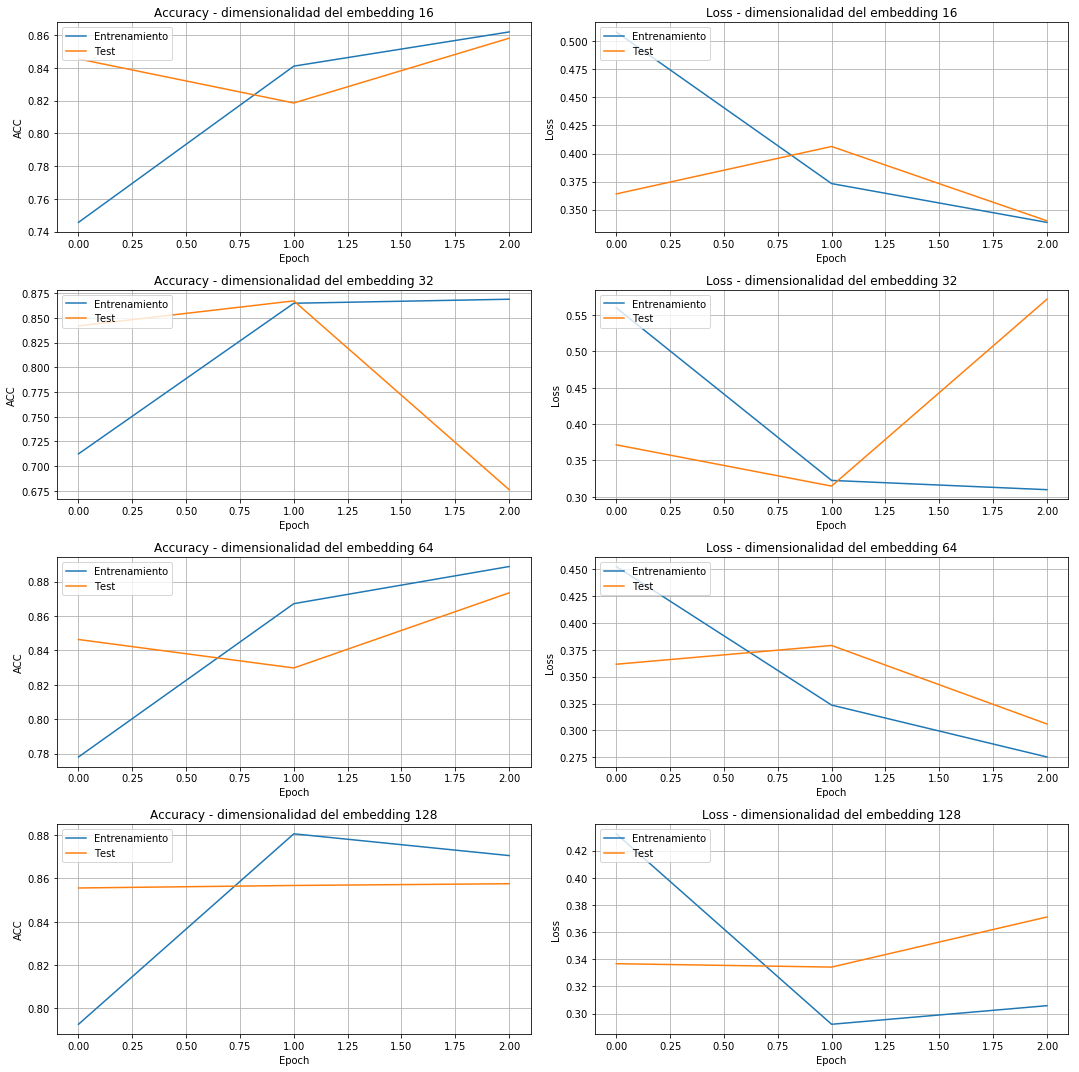

In [74]:
plt.figure(figsize=(15, 15))
#####
plt.subplot(4, 2, 1)
plt.plot(history_caso_16.history['acc'])  
plt.plot(history_caso_16.history['val_acc'])  
plt.title('Accuracy - dimensionalidad del embedding 16')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(4, 2, 2)
plt.plot(history_caso_16.history['loss'])  
plt.plot(history_caso_16.history['val_loss'])  
plt.title('Loss - dimensionalidad del embedding 16')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)
######
plt.subplot(4, 2, 3)
plt.plot(history_caso_32.history['acc'])  
plt.plot(history_caso_32.history['val_acc'])  
plt.title('Accuracy - dimensionalidad del embedding 32')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(4, 2, 4)
plt.plot(history_caso_32.history['loss'])  
plt.plot(history_caso_32.history['val_loss'])  
plt.title('Loss - dimensionalidad del embedding 32')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

#######

plt.subplot(4, 2, 5)
plt.plot(history_caso_64.history['acc'])  
plt.plot(history_caso_64.history['val_acc'])  
plt.title('Accuracy - dimensionalidad del embedding 64')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(4, 2, 6)
plt.plot(history_caso_64.history['loss'])  
plt.plot(history_caso_64.history['val_loss'])  
plt.title('Loss - dimensionalidad del embedding 64')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)
####

plt.subplot(4, 2, 7)
plt.plot(history_caso_128.history['acc'])  
plt.plot(history_caso_128.history['val_acc'])  
plt.title('Accuracy - dimensionalidad del embedding 128')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(4, 2, 8)
plt.plot(history_caso_128.history['loss'])  
plt.plot(history_caso_128.history['val_loss'])  
plt.title('Loss - dimensionalidad del embedding 128')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()